In [1]:
import nltk 
import pandas as pd
import re
import numpy as np
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Flatten

from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
df = pd.read_csv('datasets/gcc_bug_report_data.csv', encoding='utf8', sep=',', parse_dates=True,low_memory=False)

In [3]:
df['long_lived?']  = df['bug_fix_time'].apply(lambda t: 1 if t > 365 else 0)


In [4]:
df.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived?
0,CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font...,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2,0
1,GCC-43111,2010-02-18,fortran,GCC,[4.5 Regression] No temporary produced for arr...,As reported by Joost VandeVondele this does no...,pault,pault,fixed,1,resolved,4,2010-02-20,0,6,2010-02-20,2,normal,2,0
2,GCC-43804,2010-04-19,target,GCC,[4.6 regression] ICE in reload_cse_simplify_op...,$ gcc/xgcc -Bgcc/ -O2 -fpic -S memusage.i \nme...,rsandifo,schwab,fixed,1,resolved,4,2013-04-12,0,29,2013-04-12,1089,normal,2,1
3,GCC-33988,2007-11-03,ada,GCC,Warning when converting between C compatible p...,The RM95 B.3.1 contains: The type chars_ptr is...,unassigned,sam,fixed,1,resolved,4,2007-12-05,0,3,2007-11-14,11,normal,2,0
4,GCC-56270,2013-02-09,tree-optimization,GCC,[4.6 Regression] loop over array of struct flo...,Created attachment 29408\nPreprocessed file co...,rguenth,4303843KIWEMNPULN,fixed,1,resolved,4,2013-04-12,0,11,2013-04-12,62,normal,2,0


In [5]:
df['long_lived?'].value_counts()

0    7085
1    2915
Name: long_lived?, dtype: int64

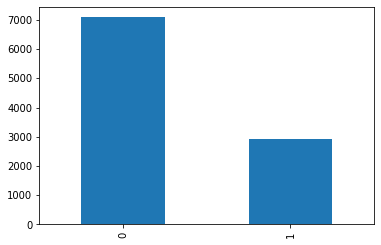

In [6]:
df['long_lived?'].value_counts().sort_values(ascending=False).plot(kind='bar', title='')

In [7]:
def print_plot(index):
    example=df.loc[df.index == index][['long_description', 'long_lived?']].values[0]
    if(len (example) > 0):
        print(example[0])
        print('long_lived?', example[1])

In [8]:
print_plot(100)

Compile testcase in attachment 23385 (bug 47786) with `gcc -v -flto -o /dev/null main.i foo.i':

/usr/local/libexec/gcc/i686-pc-linux-gnu/4.6.0/cc1 -fpreprocessed main.i foo.i -quiet -dumpbase main.i -mtune=generic -march=pentiumpro -auxbase main -version -flto -o /tmp/cc3eBz9m.s

I don't think it is an intended behavior.
long_lived? 0


In [9]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    if text != text:
        return ' '
    
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['long_description'] = df['long_description'].apply(clean_text)
df['long_description'] = df['long_description'].str.replace('\d+', '')

In [10]:
print_plot(100)

compile testcase attachment  bug  gcc v flto dev null maini fooi usr local libeec gcc ipclinugnu  cc fpreprocessed maini fooi quiet dumpbase maini mtunegeneric marchpentiumpro aubase main version flto tmp ccebzmsi dont think intended behavior
long_lived? 0


In [11]:
MAX_NB_WORDS        = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM       = 100

# Vectorize a text corpus, by turning each text into sequence of integers
# (each integer being index of a token dictionary) or into a vector where
# the coefficient for each token could be binary, based on word count, base 
# on tf-idf
#
# Arguments:
#    
#    num_words: the maximum number of words to keep, based on word frequency. 
#    filters  : a string where each element is a character that will be filtered from the texts.
#    lower    : boolean. Whether to convert to texts to lowercase.
tokenizer = Tokenizer(num_words=MAX_NB_WORDS
                      , filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
                      , lower=True)


# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency.
tokenizer.fit_on_texts(df['long_description'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))




Found 148064 unique tokens.


In [12]:
# Transforms each text in texts to a sequence of integers.
X = tokenizer.texts_to_sequences(df['long_description'].values)
#X = tokenizer.texts_to_matrix(df['long_description'].values, mode="tfidf")
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [13]:
Y = pd.get_dummies(df['long_lived?']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 2)


In [14]:
# Split arrays or matrices into random train and test subsets
# 
# Arguments:
# 
#   *arrays   - allowed input are lists, numpy arrays, scipy-sparce matrices or pandas dataframes.
#   test_size - if float, should be between 0.0 and 1.0 and represent the proportion of dataset to include
#               in test split. If int, represents the absolute number of test samples. If None, the value 
#               is set to the complement of the train size. If train_size is also None, it will set to 0.25
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(9000, 250) (9000, 2)
(1000, 250) (1000, 2)


In [86]:
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D
# The Sequential is a linear stack of layers
model = Sequential()

# Input Layer:
# ----------------------------------------------------------------------------
# The model needs to know what input shape it should expect. For this reason, 
# the first layer in a Sequential model (and only the first, because following 
# layers can do automatic shape inference) needs to receive information about 
# its input shape.
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=X.shape[1]))
#model.add(Flatten())
# input_dim    : size of the vocabulary, i.e. maximum integer index + 1; 
# output_dim   : dimension of the dense embedding; 
# input_length : length of input sequences, when it is constant. This argument is required if you 
# are going to connect Flatten then Dense layers upstream (without it, the shape of dense outputs
# cannot be computed)


# Hidden Layer: 1
# ----------------------------------------------------------------------------
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# Hidden Layer: 2
# ----------------------------------------------------------------------------
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))

# Hidden Layer: 3
# ----------------------------------------------------------------------------
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))

# Hidden Layer: 4
# ----------------------------------------------------------------------------
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))

# Output Layer: 
# ----------------------------------------------------------------------------
model.add(Dense(2,  activation='sigmoid'))

#model.add(Dense(64,input_shape=(100,)))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
#model.add(Dense(64))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
#model.add(Dense(1))
#odel.add(Activation('sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

epochs     = 5
batch_size = 64
history    = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=100
                       , validation_split=0.1
                       , callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 250, 100)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking target: expected dense_30 to have shape (1,) but got array with shape (2,)

In [80]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1000/1000 [==============================] - 10s 10ms/step
Test set
  Loss: 0.823
  Accuracy: 0.729


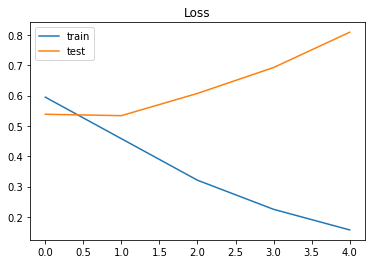

In [81]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

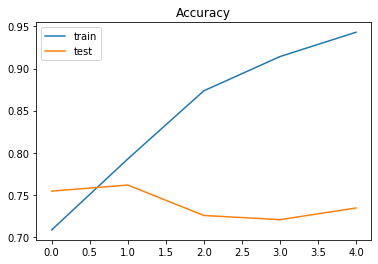

In [82]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.show();

In [83]:
Y_pred = model.predict_classes(X_test)

In [84]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  ba = ((cm[1][1]/(cm[1][1]+cm[1][0])) + (cm[0][0]/(cm[0][0]+cm[0][1]))) / 2
  print('Short-lived (True Negatives): ', cm[0][0])
  print('Short-lived Missed (False Positives): ', cm[0][1])
  print('Long-Lived (True Positives): ', cm[1][1])
  print('Long-Lived Missed (False Negatives): ', cm[1][0])
  print('Total Of Long-Liveds: ', np.sum(cm[1]))
  print('Balanced Accuracy: ', ba)

Short-lived (True Negatives):  628
Short-lived Missed (False Positives):  80
Long-Lived (True Positives):  104
Long-Lived Missed (False Negatives):  188
Total Of Long-Liveds:  292
Balanced Accuracy:  0.621585016639579


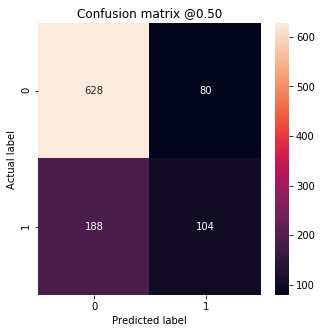

In [85]:
plot_cm(Y_test.argmax(axis=1), Y_pred)

In [78]:
from sklearn.metrics import accuracy_score, recall_score

print('Classificações corretas =', accuracy_score(Y_test.argmax(axis=1), Y_pred, normalize=False))
print('Acurácia =', accuracy_score(Y_test.argmax(axis=1), Y_pred))
print('Acurácia normalizada =', recall_score(Y_test.argmax(axis=1), Y_pred, average='macro'))

Classificações corretas = 720
Acurácia = 0.72
Acurácia normalizada = 0.6251838093026856
